In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow import keras

import numpy as np
from keras import layers
import tensorflow_addons as tfa
import random
import matplotlib.pyplot as plt

import cv2 as cv
import datetime
import os

AUTOTUNE = tf.data.AUTOTUNE
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [2]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, profile_batch=(1, 10))


In [11]:
root_dir = "../objdetection/tfrecords_detection"
IMG_W = 224
IMG_H = 224
S = 14 # number of grid cells in  the output
D = 5 # depth of each grid cells
batch_size = 256


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "S": tf.io.FixedLenFeature([], tf.int64), # output grid cells
        "D": tf.io.FixedLenFeature([], tf.int64), # depth of each grid cell
        "yolo_boxes": tf.io.FixedLenFeature([S*S*D], tf.float32), # S*S*D
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)    
    
    return example


noise = tf.random.normal(shape=(32, IMG_H,IMG_W,3), mean=0.0, stddev=16, dtype=tf.float32)    

# cria arquivos de treinamento
def prepare_sample_train(features):
    rand = tf.random.uniform([5])    
    image = tf.cast(features["image"], dtype=tf.float32)
    image = tf.image.resize(image, size=(IMG_H, IMG_W))   
    
    #format(x, 'b').zfill(n)
    rand_int = np.random.randint(0, 31)
    augment_op = format(rand_int, 'b').zfill(5)
    
    # BRIGHTNESS
    if augment_op[0] == '1':
        aux_image = tf.image.random_brightness(image, 0.8)    # org 0.5
        image = ((1-rand[1])*image + rand[1]*aux_image)    
 
    # HUE
    if augment_op[1] == '1':
        aux_image = tf.image.random_hue(image, 0.10)
        image = ((1-rand[2])*image + rand[2]*aux_image)
    
    # CONTRAST
    if augment_op[2] == '1':
        aux_image = tf.clip_by_value(tf.image.random_contrast(image, 0.5, 1.8), 0, 255)
        image = ((1-rand[3])*image + rand[3]*aux_image)

    # # CROP
    # if augment_op[3] == '1':
    #     image = tf.image.random_crop(image, (IMG_H-20, IMG_W-20, 3))
    #     image = tf.image.resize(image, size=(IMG_H, IMG_W))
        
    # NOISE    
    if augment_op[4] == '1':
        aux_image = image + (noise[rand_int] * rand[4])
        image = tf.clip_by_value(aux_image, 0.0, 255)
    
    # clip img
    image = tf.clip_by_value(image, 0.0, 255)
    
    output_batch = tf.reshape(features["yolo_boxes"], [S, S, D])
    return image, output_batch


# cria arquivos de valid
def prepare_sample_valid(features):
    image = tf.cast(features["image"], dtype=tf.float32)  
    image = tf.image.resize(image, size=(IMG_H, IMG_W))   
    # output_label = tf.reshape(features["yolo_boxes"], [10,10,5])   
    output_batch = tf.reshape(features["yolo_boxes"], [S, S, D])
    return image, output_batch


def get_train_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample_train, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset

def get_valid_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample_valid, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset

In [12]:
""" converte centroid relativo à grid para centroid relativo imagem """
def grid_relative_to_img(x_grid_relative, y_grid_relative, grid_x, grid_y, S):    
    x_img_relative = (x_grid_relative+grid_x)/S
    y_img_relative = (y_grid_relative+grid_y)/S
    return [x_img_relative, y_img_relative]



def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2)
    box_maxes = box_xy + (box_wh / 2)

    return tf.concat([        
        box_mins[..., 0:1],  # x_min
        box_mins[..., 1:2],  # y_min        
        box_maxes[..., 0:1],  # x_max
        box_maxes[..., 1:2]  # y_max
    ], -1)


def output_to_yolo(output_batch, S, D, IMG_W):
    # cria indice de cada grid para o batch
    rng = tf.range(0, S, dtype=tf.float32)
    gridy, gridx = tf.meshgrid(rng, rng)
    grid_x_indices = tf.expand_dims(tf.expand_dims(gridx, -1), 0)
    grid_y_indices = tf.expand_dims(tf.expand_dims(gridy, -1), 0)

    # scores de cada bbox
    scores = output_batch[..., 0:1]  

    # escala as caixas de saída
    boxes_x = ((output_batch[..., 1:2] + grid_x_indices) / S) #* IMG_W
    boxes_y = ((output_batch[..., 2:3] + grid_y_indices) / S) #* IMG_H
    boxes_w = (output_batch[..., 3:4] ) #* IMG_W
    boxes_h = (output_batch[..., 4:5] ) #* IMG_H

    # concatena coordenadas e dimensoes (y, x) em vez de (x, y) por conta da função do TF
    boxes_yx = tf.concat([boxes_y, boxes_x], -1)
    boxes_hw = tf.concat([boxes_h, boxes_w], -1)

    bbox_corners = tf.clip_by_value(yolo_boxes_to_corners(boxes_yx, boxes_hw), 0, 1)

    ############################

    # flatten scores and bboxes
    scores = tf.reshape(scores, [-1, S*S, 1])
    bbox_corners = tf.reshape(bbox_corners, [-1, S*S, 1, 4])

    bbox_nms = tf.image.combined_non_max_suppression(bbox_corners, scores, 10, max_total_size=10, iou_threshold=0.1, score_threshold=0.4, clip_boxes=False) 
    boxes = bbox_nms.nmsed_boxes  
    
    return boxes


def scale_boxes():
    print("not implementend")
    

def draw_boxes(imagens, boxes, colors = np.array([[0.0, 255., 0.0, 1.0]])):
    
    if len(imagens.shape) < 4:
        imagens = tf.expand_dims(imagens,0)
    
    drawed_imgs = tf.image.draw_bounding_boxes(tf.cast(imagens, tf.float32), boxes, colors = colors)
    
    return drawed_imgs


['..\\objdetection\\tfrecords_detection\\train\\file_00-8192.tfrec', '..\\objdetection\\tfrecords_detection\\train\\file_01-268.tfrec']


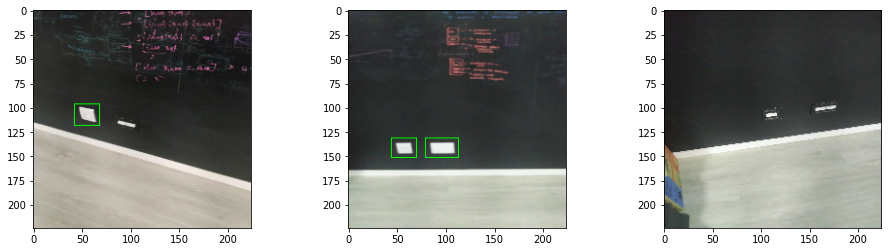

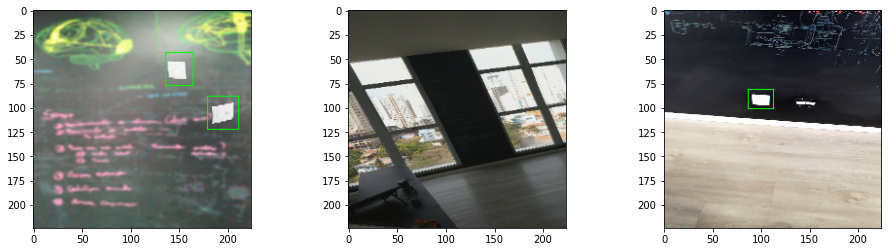

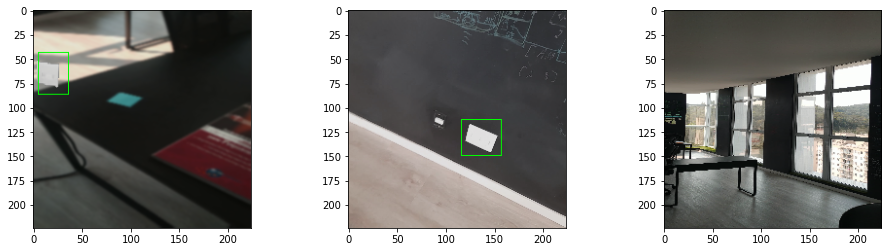

In [13]:
train_filenames = tf.io.gfile.glob(f"../objdetection/tfrecords_detection/train/*.tfrec")
print(train_filenames)
train_ds = get_train_dataset(train_filenames, batch_size)


for data in train_ds.take(3).as_numpy_iterator():
    output_batch = data[1]            
    
    bbox_corners = output_to_yolo(output_batch, S, D, IMG_W)
    
    drawed_imgs =  draw_boxes(data[0], bbox_corners)
           
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))       
    
    ax1.imshow(drawed_imgs[0] /255.)
    ax2.imshow(drawed_imgs[1] /255.)
    ax3.imshow(drawed_imgs[2] /255.)
   
    plt.show()



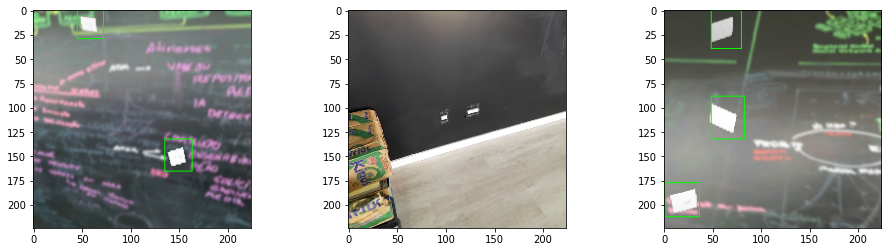

In [14]:

val_filenames = tf.io.gfile.glob(f"../objdetection/tfrecords_detection/val/*.tfrec")

valid_ds = get_valid_dataset(val_filenames, batch_size)

for data in valid_ds.take(3).as_numpy_iterator():
    output_batch = data[1]            
    
    bbox_corners = output_to_yolo(output_batch, S, D, IMG_W)
    
    drawed_imgs =  draw_boxes(data[0], bbox_corners)
       
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))       
    
    ax1.imshow(drawed_imgs[0] /255.)
    ax2.imshow(drawed_imgs[1] /255.)
    ax3.imshow(drawed_imgs[2] /255.)
   
    plt.show()
    

In [15]:
# get pre-trained model as backend
base_model = keras.applications.MobileNetV3Small(
    weights=None,  # Load weights pre-trained on ImageNet.
    alpha=1.5,
    input_shape=(224, 224, 3), 
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = True

In [ ]:
from keras import Model
model = Model(inputs=base_model.input, outputs=base_model.get_layer('multiply_6').output)

# add a global spatial average pooling layer
x = model.output
x = keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(0.0005), activation="relu")(x)
#x = keras.layers.MaxPooling2D()(x)
#x = keras.layers.Conv2D(64, (5,5), padding='same', kernel_regularizer=keras.regularizers.l2(0.0005), activation="relu")(x)
predictions = keras.layers.Conv2D(5, (3,3), padding='same', kernel_regularizer=keras.regularizers.l2(0.0005), activation="linear", name="output_layer")(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


In [17]:
def YOLO_loss(y_true, y_pred):
    # confidence of each grid bbox
    pred_bbox_conf = tf.sigmoid(y_pred[..., 0])
    true_bbox_conf = y_true[..., 0]    
    
    # xy predictions
    pred_bbox_xy = tf.sigmoid(y_pred[..., 1:3])
    true_bbox_xy = y_true[..., 1:3]

    # wh predictions
    pred_bbox_wh = tf.sigmoid(y_pred[..., 3:])
    true_bbox_wh = y_true[..., 3:]
    
    ############
    
    confidence_loss = 1.0 * tf.reduce_sum(tf.multiply(tf.pow(true_bbox_conf - pred_bbox_conf, 2), true_bbox_conf), [-1, -2])
    
    coordinate_loss = tf.reduce_sum(tf.multiply(tf.reduce_sum(tf.pow(true_bbox_xy - pred_bbox_xy, 2), -1), true_bbox_conf), [-1, -2])
    coordinate_loss += tf.reduce_sum(tf.multiply(tf.reduce_sum(tf.pow(tf.sqrt(true_bbox_wh) - tf.sqrt(pred_bbox_wh), 2), -1), true_bbox_conf), [-1, -2])
    coordinate_loss *= 5.0
    
    no_obj_loss = 0.5 * tf.reduce_sum(tf.multiply(tf.pow(true_bbox_conf - pred_bbox_conf, 2), (1-true_bbox_conf)), [-1, -2])
    
    
    loss = confidence_loss + coordinate_loss + no_obj_loss
    
    return loss

Epoch 1/10
34/34 [==============================] - 16s 359ms/step - loss: 1.2493 - YOLO_loss: 1.2155 - val_loss: 23.8438 - val_YOLO_loss: 23.8078
Epoch 2/10
34/34 [==============================] - 9s 225ms/step - loss: 1.0463 - YOLO_loss: 1.0164 - val_loss: 23.6536 - val_YOLO_loss: 23.6225
Epoch 3/10
34/34 [==============================] - 9s 225ms/step - loss: 0.9358 - YOLO_loss: 0.9079 - val_loss: 24.1838 - val_YOLO_loss: 24.1562
Epoch 4/10
34/34 [==============================] - 9s 221ms/step - loss: 0.8312 - YOLO_loss: 0.8035 - val_loss: 24.4810 - val_YOLO_loss: 24.4613
Epoch 5/10
34/34 [==============================] - 9s 222ms/step - loss: 0.7539 - YOLO_loss: 0.7256 - val_loss: 24.2628 - val_YOLO_loss: 24.2290
Epoch 6/10
34/34 [==============================] - 9s 227ms/step - loss: 0.7094 - YOLO_loss: 0.6807 - val_loss: 24.2475 - val_YOLO_loss: 24.2159
Epoch 7/10
34/34 [==============================] - 10s 235ms/step - loss: 0.6651 - YOLO_loss: 0.6361 - val_loss: 25.0917 -

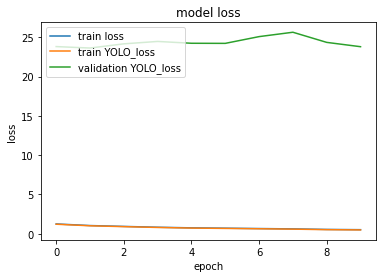

In [18]:
#model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(), #1e-5
                  loss = YOLO_loss,
                metrics=[YOLO_loss])


#loss='CategoricalCrossentropy', metrics=["accuracy"])
history = model.fit(train_ds, epochs=10, validation_data=valid_ds, callbacks=[tensorboard_callback])

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['YOLO_loss'])
plt.plot(history.history['val_YOLO_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'train YOLO_loss', 'validation YOLO_loss'], loc='upper left')
plt.show()

In [ ]:
model.save("modelos/detection/modeloS15/")

# finetune

In [ ]:
#model = tf.keras.models.load_model("modelos/detection/modeloSynthFinetuned4/", custom_objects={"YOLO_loss":YOLO_loss})
for l in enumerate(model.layers):
    if l[0] >= 97:                
        print(l[0], l[1].name)
        l[1].trainable = True
    else:
        print(l[0], l[1].name)
        l[1].trainable = False
#model.summary()    

In [ ]:

for data in valid_ds.take(1).as_numpy_iterator():
    output_batch = tf.sigmoid(model(data[0])) # data[1] #    
    output_labels = data[1] #    
    
    # cria indice de cada grid para o batch
    rng = tf.range(0, S, dtype=tf.float32)
    gridy, gridx = tf.meshgrid(rng, rng)
    grid_x_indices = tf.expand_dims(tf.expand_dims(gridx, -1), 0)
    grid_y_indices = tf.expand_dims(tf.expand_dims(gridy, -1), 0)
    
    # scores de cada bbox
    scores = output_batch[..., 0:1]    
    
    # escala as caixas de saída
    boxes_x = ((output_batch[..., 1:2] + grid_x_indices) / S) #* IMG_W
    boxes_y = ((output_batch[..., 2:3] + grid_y_indices) / S) #* IMG_H
    boxes_w = (output_batch[..., 3:4] ) #* IMG_W
    boxes_h = (output_batch[..., 4:5] ) #* IMG_H
       
    # concatena coordenadas e dimensoes (y, x) em vez de (x, y) por conta da função do TF
    boxes_yx = tf.concat([boxes_y, boxes_x], -1)
    boxes_hw = tf.concat([boxes_h, boxes_w], -1)    
    bbox_corners = yolo_boxes_to_corners(boxes_yx, boxes_hw)
    ############################
    
    # flatten scores and bboxes
    scores = tf.reshape(scores, [-1, S*S, 1])
    bbox_corners = tf.reshape(bbox_corners, [-1, S*S, 1, 4])        
    bbox_nms = tf.image.combined_non_max_suppression(bbox_corners, scores, 10, max_total_size=10, iou_threshold=0.1, score_threshold=0.4, clip_boxes=False)     
    boxes = bbox_nms.nmsed_boxes            
    drawed_imgs = tf.image.draw_bounding_boxes(data[0], boxes, colors = np.array([[0.0, 255., 0.0, 1.0]]))
    
    
        
    labels_bbox_corners = output_to_yolo(output_labels, S, D, IMG_W)    
    drawed_imgs2 =  draw_boxes(drawed_imgs, labels_bbox_corners, np.array([[255., 0., 0.0, 1.0]]))    
            
                
    for img in drawed_imgs2:
        fig, ax = plt.subplots(1, 1, figsize=(16,4))    
        ax.imshow(img /255.)
        plt.show()        
    



In [ ]:
model.save("modelos/detection/modelfinalv6/")
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='output_layer' --saved_model_tags=serve "modelos/detection/modelfinalv6"  "modelos/detection/web_model"

In [ ]:
model = tf.keras.models.load_model("modelos/detection/modelotf/", custom_objects={"YOLO_loss":YOLO_loss})

In [ ]:
img = cv.imread("../dataset/imagens/3/110_1.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize=(16,4))    
ax.imshow(img /255.)
plt.show()   
print(img.shape)

In [ ]:
output_batch = tf.sigmoid(model(tf.expand_dims(img, 0)))
print(output.shape)

In [ ]:
S = 7

# cria indice de cada grid para o batch
rng = tf.range(0, S, dtype=tf.float32)
gridy, gridx = tf.meshgrid(rng, rng)
grid_x_indices = tf.expand_dims(tf.expand_dims(gridx, -1), 0)
grid_y_indices = tf.expand_dims(tf.expand_dims(gridy, -1), 0)

# scores de cada bbox
scores = output_batch[..., 0:1]  

# escala as caixas de saída
boxes_x = ((output_batch[..., 1:2] + grid_x_indices) / S) #* IMG_W
boxes_y = ((output_batch[..., 2:3] + grid_y_indices) / S) #* IMG_H
boxes_w = (output_batch[..., 3:4] ) #* IMG_W
boxes_h = (output_batch[..., 4:5] ) #* IMG_H

# concatena coordenadas e dimensoes (y, x) em vez de (x, y) por conta da função do TF
boxes_yx = tf.concat([boxes_y, boxes_x], -1)
boxes_hw = tf.concat([boxes_h, boxes_w], -1)

bbox_corners = tf.clip_by_value(yolo_boxes_to_corners(boxes_yx, boxes_hw), 0, 1)

############################

# flatten scores and bboxes
scores = tf.reshape(scores, [-1, S*S, 1])
bbox_corners = tf.reshape(bbox_corners, [-1, S*S, 1, 4])

bbox_nms = tf.image.combined_non_max_suppression(bbox_corners, scores, 10, max_total_size=10, iou_threshold=0.1, score_threshold=0.4, clip_boxes=False) 
boxes = bbox_nms.nmsed_boxes    

drawed_imgs = tf.image.draw_bounding_boxes(tf.cast(tf.expand_dims(img,0), tf.float32), boxes, colors = np.array([[0.0, 255., 0.0, 1.0]]))


for img in drawed_imgs:
    fig, ax = plt.subplots(1, 1, figsize=(16,4))    
    ax.imshow(img /255.)
    plt.show()     

In [ ]:
import glob

IMG_TEST_PATH = "../dataset/imagens/3/*"

test_imgs_paths = glob.glob(IMG_TEST_PATH)
random.shuffle(test_imgs_paths)

for img_path in test_imgs_paths[:50]:
    img_path = img_path.replace("\\", "/")
    print(img_path)
    
    img = cv.imread(img_path)        
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    output_batch = tf.sigmoid(model(tf.cast(tf.expand_dims(img, 0), tf.float32)))
    bboxes = output_to_yolo(output_batch, S, D, IMG_H)
        
    imgs = draw_boxes(img, bboxes)        
    
    fig, ax = plt.subplots(1, 1, figsize=(16,4))    
    ax.imshow(imgs[0] /255.)
    plt.show()
    
    
    
